In [1]:
'''

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/ENEL645/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

'\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/content/gdrive/MyDrive/ENEL645/chest_xray/\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n'

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

!pip install tensorflow
!pip install keras
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install sklearn
!pip install glob
!pip install cv2

Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom

In [3]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg   
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from keras.metrics import AUC, Accuracy, Precision, SensitivityAtSpecificity
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

2023-03-19 18:53:26.110999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 18:53:27.387866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-19 18:53:27.388277: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-19 18:53:27.388340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [6]:
#main_path = "./chest_xray_data/"
# main_path = "G:/My Drive/datasets/xray-pneumonia/chest_xray/chest_xray/"
#main_path = "/content/drive/MyDrive/Colab Notebooks/chest_xray_data"

train_path = "train"
test_path= "test"

train_normal = glob.glob("train/NORMAL/*.jpeg")
train_pneumonia = glob.glob("train/PNEUMONIA/*.jpeg")

test_normal = glob.glob("test/NORMAL/*.jpeg")
test_pneumonia = glob.glob("test/PNEUMONIA/*.jpeg")

In [7]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

# <a id="3">Exploring the Data</a> 

Let's check the target distribution on each set

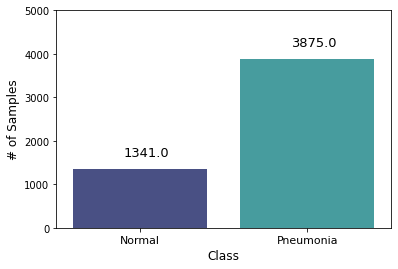

In [8]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

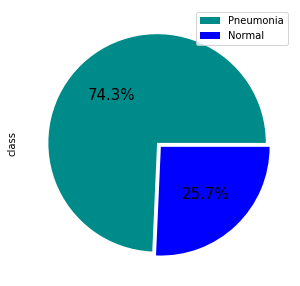

In [9]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

Train Set - Normal


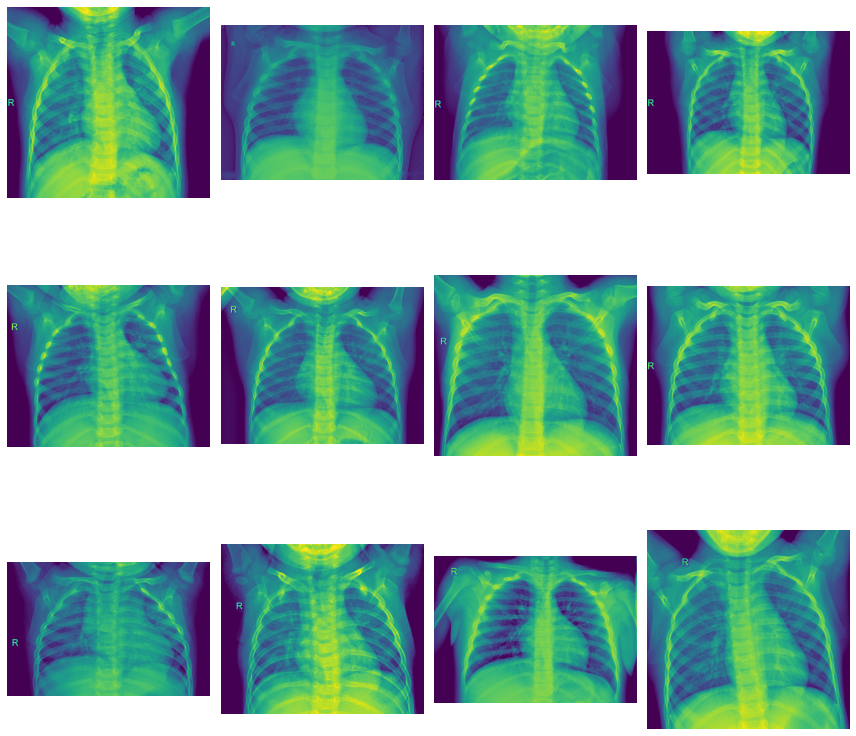

In [10]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = mpimg.imread(train_normal[i])
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


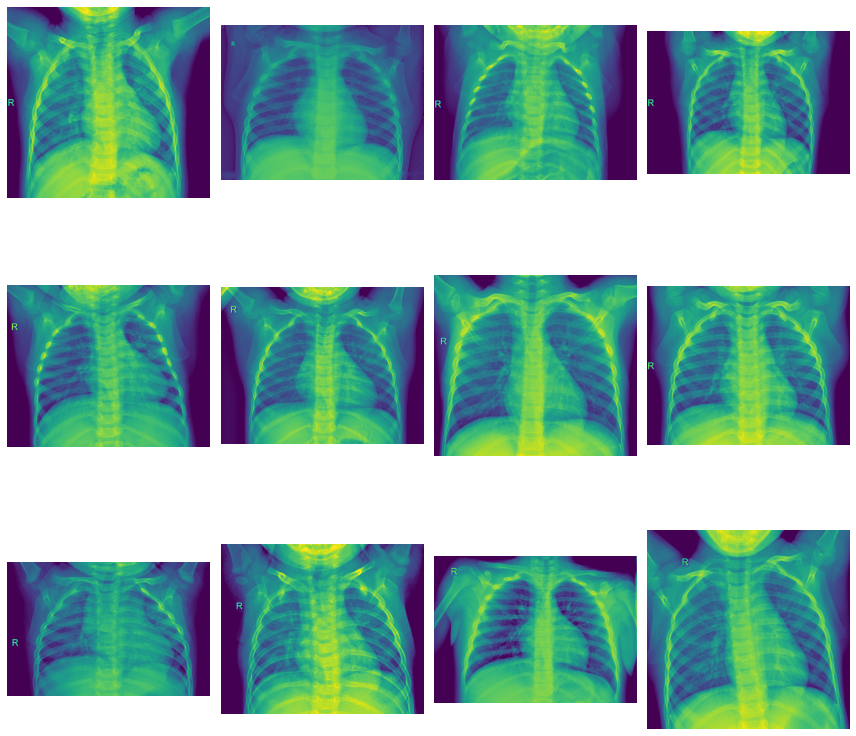

In [11]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = mpimg.imread(train_normal[i])
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

# <a id="4">Preparing the Data</a> 

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [12]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

Now, we’re going to load the images from the folders and prepare them to feed our models. 

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [13]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


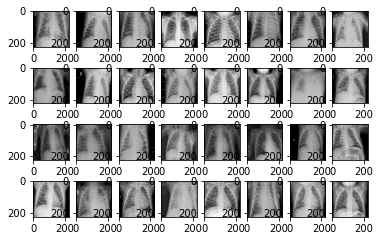

In [14]:
# retrieve a batch of images from the data generator
x_batch, y_batch = next(ds_train)
# plot the first 9 images in the batch
for i in range(32):
    # define subplot
    plt.subplot(4,8,i + 1)
    # plot raw pixel data
    plt.imshow(x_batch[i])
# show the figure
plt.show()

Now, we are ready for the next stage: creating and training the image classification models.

# <a id="5">Transfer Learning</a> 

The approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the ResNet152V2 available on the Keras Package [(link)](https://keras.io/api/applications/resnet/#resnet152v2-function). 

This model was already trained in another dataset (ImageNet). What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.



In [15]:
base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

2023-03-19 18:54:42.724305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 18:54:43.435596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11306 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0


In [16]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

# define the ModelCheckpoint callback
checkpoint_path = "model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      save_best_only=True)

In [17]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [18]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 30,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau, checkpoint_callback],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/30


2023-03-19 18:55:11.723237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-03-19 18:55:12.115807: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-19 18:55:12.116543: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-19 18:55:12.116627: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-19 18:55:12.117157: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-19 18:55:12.117303: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-19 18:55:12.970652:

130/130 [==============================] - 214s 2s/step - loss: 0.3448 - binary_accuracy: 0.8576 - val_loss: 0.2080 - val_binary_accuracy: 0.9205 - lr: 5.0000e-05
Epoch 2/30
130/130 [==============================] - 209s 2s/step - loss: 0.1893 - binary_accuracy: 0.9334 - val_loss: 0.1753 - val_binary_accuracy: 0.9301 - lr: 5.0000e-05
Epoch 3/30
130/130 [==============================] - 191s 1s/step - loss: 0.1568 - binary_accuracy: 0.9446 - val_loss: 0.1452 - val_binary_accuracy: 0.9454 - lr: 5.0000e-05
Epoch 4/30
130/130 [==============================] - 175s 1s/step - loss: 0.1337 - binary_accuracy: 0.9545 - val_loss: 0.1283 - val_binary_accuracy: 0.9511 - lr: 5.0000e-05
Epoch 5/30
130/130 [==============================] - 189s 1s/step - loss: 0.1298 - binary_accuracy: 0.9552 - val_loss: 0.1175 - val_binary_accuracy: 0.9559 - lr: 5.0000e-05
Epoch 6/30
130/130 [==============================] - 184s 1s/step - loss: 0.1183 - binary_accuracy: 0.9569 - val_loss: 0.1078 - val_binary_a

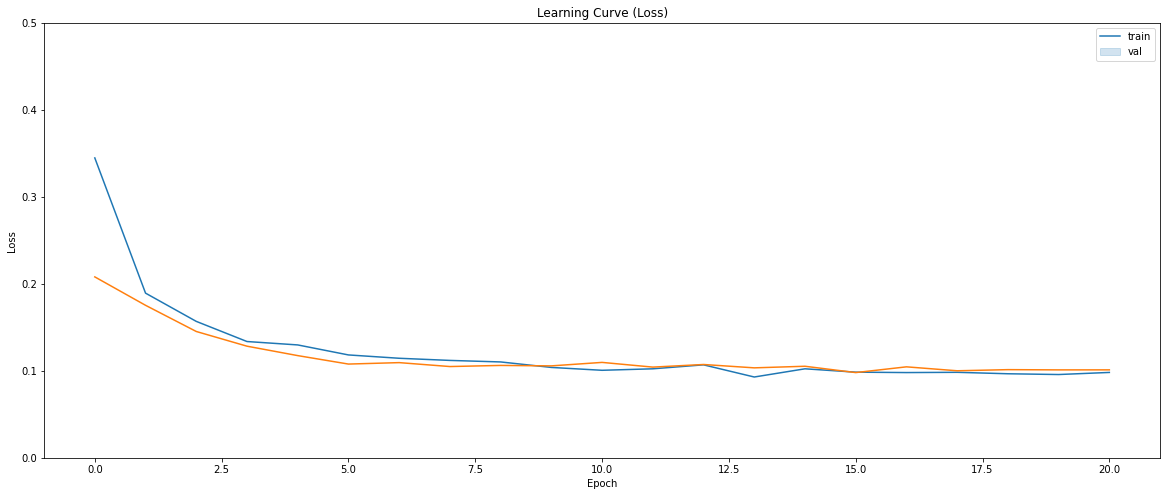

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

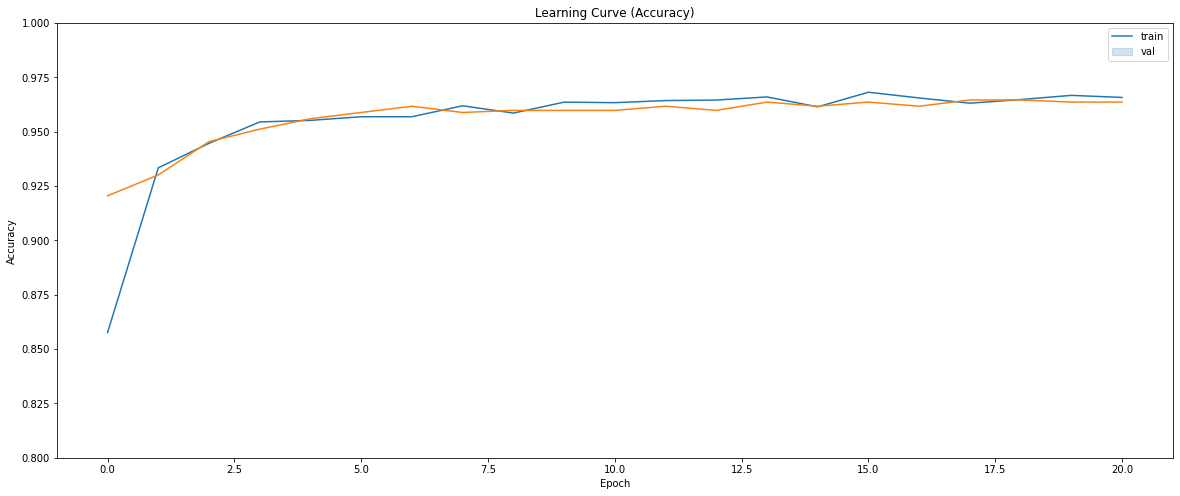

In [20]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [21]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.09797900915145874
Val accuracy: 0.9636015295982361


In [22]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.42788976430892944
Test accuracy: 0.8509615659713745


# <a id="7">Fine Tuning</a> 

Our last approach is called Fine Tuning. In the last section, all the layers from the pretrained model were ‘frozen’, preserving the weights calculated during its training on the ImageNet dataset. Now, we are going to unfreeze a few of its last layers and continue the training, tuning the weights from these layers according to our dataset.

In [23]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [24]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [25]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [26]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 30,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau, checkpoint_callback],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/30
130/130 [==============================] - 207s 1s/step - loss: 0.1828 - binary_accuracy: 0.9360 - val_loss: 0.1581 - val_binary_accuracy: 0.9473 - lr: 2.0000e-06
Epoch 2/30
130/130 [==============================] - 185s 1s/step - loss: 0.1517 - binary_accuracy: 0.9499 - val_loss: 0.1440 - val_binary_accuracy: 0.9540 - lr: 2.0000e-06
Epoch 3/30
130/130 [==============================] - 156s 1s/step - loss: 0.1438 - binary_accuracy: 0.9561 - val_loss: 0.1362 - val_binary_accuracy: 0.9540 - lr: 2.0000e-06
Epoch 4/30
130/130 [==============================] - 162s 1s/step - loss: 0.1274 - binary_accuracy: 0.9607 - val_loss: 0.1287 - val_binary_accuracy: 0.9550 - lr: 2.0000e-06
Epoch 5/30
130/130 [==============================] - 158s 1s/step - loss: 0.1265 - binary_accuracy: 0.9573 - val_loss: 0.1267 - val_binary_accuracy: 0.9550 - lr: 2.0000e-06
Epoch 6/30
130/130 [==============================] - 163s 1s/step - loss: 0.1244 - binary_accuracy: 0.9578 - val_loss: 0.1249 - v

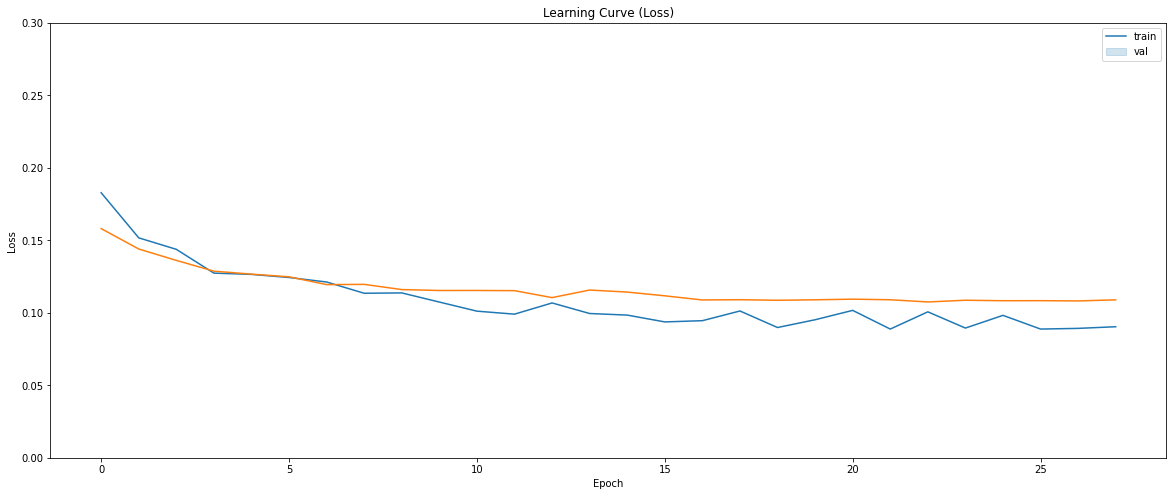

In [27]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

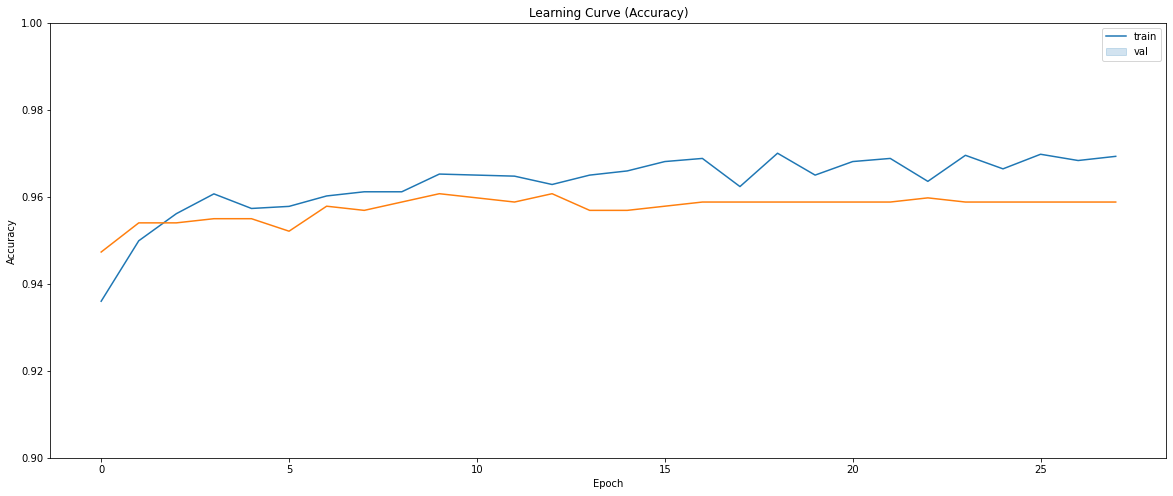

In [28]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [29]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1074952483177185
Val accuracy: 0.959770143032074


In [30]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.34242677688598633
Test accuracy: 0.8669871687889099


As expected, the fine-tuning approach has reached the best score. We end this notebook by showing a few performance metrics.

# <a id="8">Performance Metrics</a> 

In [31]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [32]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [33]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.8669871794871795


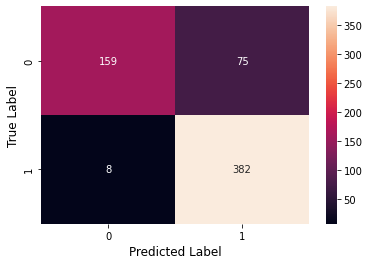

In [34]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [35]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79       234
           1       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



ROC_AUC:  0.9621959237343852


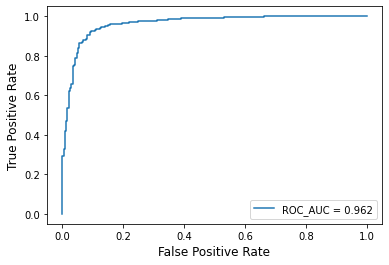

In [36]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

The recall was close to 100%. Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.

In [2]:
from transformers import ViTFeatureExtractor, TFAutoModel

# Load the ViT feature extractor and the pre-trained ViT model with imagenet weights
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = TFAutoModel.from_pretrained('google/vit-base-patch16-224', from_pt=True)

# Add a dense layer for classification
x = model.outputs[0]
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create a new model with the added dense layer
new_model = tf.keras.models.Model(inputs=model.inputs, outputs=predictions)

# Freeze the layers of the pre-trained model to avoid retraining them
for layer in model.layers:
    layer.trainable = False
new_model.summary()

c:\Users\nourn\anaconda3\envs\tf2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nourn\anaconda3\envs\tf2\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nourn\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: h